In [1]:
import datetime as dt
import pandas as pd
import numpy as np
from bisect import bisect_left, bisect_right
import matplotlib.pyplot as plt

## Set up Stage Names and Relative Biomass accumulaiton at each stage

In [2]:
#Standard Stage names
Stages = ['Emergence','Seedling','Vegetative','EarlyReproductive','MidReproductive','LateReproductive','Maturity','Late']
#Proportion of total biomass accumulated at each standard stage (these give y scale)
PrpnMaxBiom = [0.018,0.05,0.5,0.7,0.86,0.95,0.9925,0.9995]
#Put the two in a dictionary
RelBiomAtStage = dict(zip(Stages,PrpnMaxBiom))

RelBiomAtStage

{'Emergence': 0.018,
 'Seedling': 0.05,
 'Vegetative': 0.5,
 'EarlyReproductive': 0.7,
 'MidReproductive': 0.86,
 'LateReproductive': 0.95,
 'Maturity': 0.9925,
 'Late': 0.9995}

## Set up Relative Development at each stage (by solving standard logistic for x)

In [3]:
# Rearrange standard logistic to solve for x with a given y and slove for relative biomass at each stage
PrpnMaxDev = []
#RelDevAtStage = pd.DataFrame(index = Methods, data = PrpnMaxDM,columns=['PrpnMaxDM']) 
#Calculate the proportion of thermal time that each stage will accumulate at and graph
for s in Stages:
    y = RelBiomAtStage[s]
    PrpnMaxDev.append((np.log((1/y)-1)*-11.25+45)/100)
RelDevAtStage = dict(zip(Stages,PrpnMaxDev))

RelDevAtStage

{'Emergence': 8.78005734411147e-05,
 'Seedling': 0.11875061484377547,
 'Vegetative': 0.45,
 'EarlyReproductive': 0.5453210092935604,
 'MidReproductive': 0.654220121246803,
 'LateReproductive': 0.7812493851562246,
 'Maturity': 0.9995989491021464,
 'Late': 1.3050452626313278}

## Derive standard logistic curve and plot with stage names

Text(0.5, 0, 'Relative development')

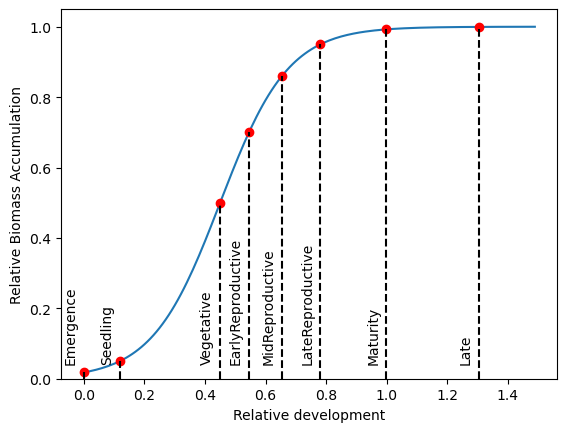

In [4]:
#Empty arrays to hold example data
BiomassScaller = []

#biomass parameters (parameters give x scale)
Tt_mat = 1  # on standard curve relative maturity is 1.0
Xo_Biomass = Tt_mat * 0.45  
b_Biomass = Xo_Biomass*0.25

#Relative Development series to represent x axis (0 - 1.5 in 150 steps)
RDs = pd.Series(range(150)).divide(100)

#Calculate biomass, cover and root depth callers at each Tt in the series
for r in RDs:
    BiomassScaller.append(1/(1+np.exp(-((r-Xo_Biomass)/(b_Biomass)))))

# Plot standard Biomass curve
plt.plot(RDs,BiomassScaller)

#Step through each stage and plot x position
for s in Stages:
    y = RelBiomAtStage[s]
    x = RelDevAtStage[s]
    plt.plot(x,y,'o',color='r')
    plt.plot([x]*2,[0,y],'--',color='k')
    plt.text(x-.02,0.05,s,rotation=90,ha = 'right')
plt.ylim(0,1.05)
plt.ylabel('Relative Biomass Accumulation')
plt.xlabel('Relative development')


## Derive height, cover and root depth patterns

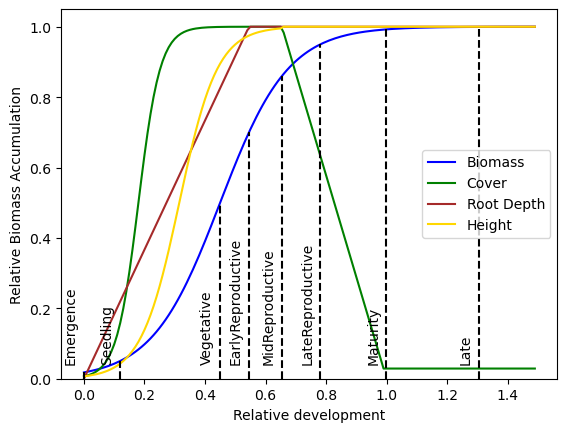

In [5]:
CoverScaller = []
RootDepthScaller = []
HeightScaller = []

Tt_maxRD = RelDevAtStage["EarlyReproductive"]*Tt_mat
Tt_maxHeight = RelDevAtStage["MidReproductive"]*Tt_mat
Tt_sen = RelDevAtStage["MidReproductive"]*Tt_mat
Xo_cov = Xo_Biomass * 0.4 
b_cov = Xo_cov * 0.2
Xo_hig = Xo_Biomass * 0.7
b_hig = Xo_hig *.2

for tt in RDs:
    if tt < Tt_maxRD:
        rd = tt/Tt_maxRD
    else:
        if tt < Tt_mat:
            rd = 1.0
    RootDepthScaller.append(rd)
    if tt < Tt_sen:
        cover = 1/(1+np.exp(-((tt-Xo_cov)/b_cov)))
        height = 1/(1+np.exp(-((tt-Xo_hig)/b_hig)))
    else:
        if tt < Tt_mat:
            cover = (1-(tt-Tt_sen)/(Tt_mat-Tt_sen))
            height = 1.0
    CoverScaller.append(cover)
    HeightScaller.append(height)
    
plt.plot(RDs,BiomassScaller,color='b',label='Biomass')
plt.plot(RDs,CoverScaller,color='g',label='Cover')
plt.plot(RDs,RootDepthScaller,color='brown',label='Root Depth')
plt.plot(RDs,HeightScaller,color='gold',label = 'Height')
for s in Stages:
    y = RelBiomAtStage[s]
    x = RelDevAtStage[s]*Tt_mat
    plt.plot([x]*2,[0,y],'--',color='k')
    plt.text(x-.02,0.05,s,rotation=90,ha = 'right')
plt.ylabel('Relative Biomass Accumulation')
plt.xlabel('Relative development')
plt.ylim(0,1.05)
plt.legend()

## Derive parameters from known establish and harvest stages and Tt between the two

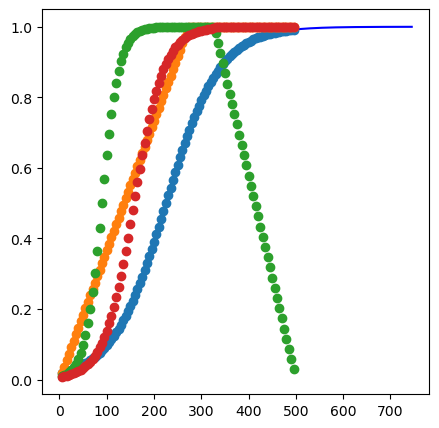

In [47]:
#Known inputs
EstabStage = 'Emergence'
HarvestStage = 'Maturity'
ttEmergeToHarv = 500  #alternatively, this may be derived from establishment and harvest date inputs

PropnTt_EstToHarv = RelDevAtStage[HarvestStage]-RelDevAtStage[EstabStage]
Tt_mat = ttEmergeToHarv * 1 / PropnTt_EstToHarv
Xo_Biomass = Tt_mat * .45
b_Biomass = Xo_Biomass * .25
Tt_PriorEstab = Tt_mat * RelDevAtStage[EstabStage]
Tt_harv = Tt_PriorEstab + ttEmergeToHarv

#Plot standard curve for specified Tt
Tts = RDs *Tt_mat
standardBiom = []
for t in Tts:
    standardBiom.append(1/(1+np.exp(-((t-Xo_Biomass)/(b_Biomass)))))
Graph = plt.figure(figsize=(5,5))
ax = Graph.add_subplot(1,1,1)
plt.plot(Tts,standardBiom,color='b')    

# Derive other variables
Xo_cov = Xo_Biomass * 0.4
b_cov = Xo_cov * 0.2
Xo_hig = Xo_Biomass * 0.7
b_hig = Xo_hig * 0.2
T_maxRD = RelDevAtStage["EarlyReproductive"]*Tt_mat
T_maxHeight = RelDevAtStage["MidReproductive"]*Tt_mat
T_sen = RelDevAtStage["MidReproductive"]*Tt_mat

Scallers = pd.DataFrame(index=Tts)
for t in Scallers.index:
    if ((t>=Tt_PriorEstab) and (t<=Tt_harv)):
        Scallers.loc[t,'Biom'] = 1/(1+np.exp(-((t-Xo_Biomass)/(b_Biomass))))
        if t < T_maxRD:
            rd = t/T_maxRD
        else:
            if t < Tt_mat:
                rd = 1.0
        Scallers.loc[t,'RD'] = rd
        if t < T_sen:
            cover = 1/(1+np.exp(-((t-Xo_cov)/b_cov)))
            height = 1/(1+np.exp(-((t-Xo_hig)/b_hig)))
        else:
            if t < Tt_mat:
                cover = (1-(t-T_sen)/(Tt_mat-T_sen))
                height = 1.0
        Scallers.loc[t,'Cover'] = cover
        Scallers.loc[t,'Height'] = height

for c in Scallers.columns:
    plt.plot(Scallers.index,Scallers.loc[:,c],'o')

In [63]:
#Known inputs
def calcScallers(EstabStage,HarvestStage,TtEmergetoHarv):

    PropnTt_EstToHarv = RelDevAtStage[HarvestStage]-RelDevAtStage[EstabStage]
    Tt_mat = ttEmergeToHarv * 1 / PropnTt_EstToHarv
    Xo_Biomass = Tt_mat * .45
    b_Biomass = Xo_Biomass * .25
    Tt_PriorEstab = Tt_mat * RelDevAtStage[EstabStage]
    Tt_harv = Tt_PriorEstab + ttEmergeToHarv

    #Plot standard curve for specified Tt
    Tts = RDs * Tt_mat
    standardBiom = []
    for t in Tts:
        standardBiom.append(1/(1+np.exp(-((t-Xo_Biomass)/(b_Biomass)))))
    
    # Derive other variables
    Xo_cov = Xo_Biomass * 0.4
    b_cov = Xo_cov * 0.2
    Xo_hig = Xo_Biomass * 0.7
    b_hig = Xo_hig * 0.2
    T_maxRD = RelDevAtStage["EarlyReproductive"]*Tt_mat
    T_maxHeight = RelDevAtStage["MidReproductive"]*Tt_mat
    T_sen = RelDevAtStage["MidReproductive"]*Tt_mat

    Scallers = pd.DataFrame(index=Tts)
    for t in Scallers.index:
        if ((t>=Tt_PriorEstab) and (t<=Tt_harv)):
            Scallers.loc[t,'Biom'] = 1/(1+np.exp(-((t-Xo_Biomass)/(b_Biomass))))
            if t < T_maxRD:
                rd = t/T_maxRD
            else:
                if t < Tt_mat:
                    rd = 1.0
                else:
                    rd = 0.0
            Scallers.loc[t,'RD'] = rd
            if t < T_sen:
                cover = 1/(1+np.exp(-((t-Xo_cov)/b_cov)))
                height = 1/(1+np.exp(-((t-Xo_hig)/b_hig)))
            else:
                if t < Tt_mat:
                    cover = (1-(t-T_sen)/(Tt_mat-T_sen))
                    height = 1.0
                else:
                    cover = 0
                    height = 0
            Scallers.loc[t,'Cover'] = cover
            Scallers.loc[t,'Height'] = height
    return Scallers


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


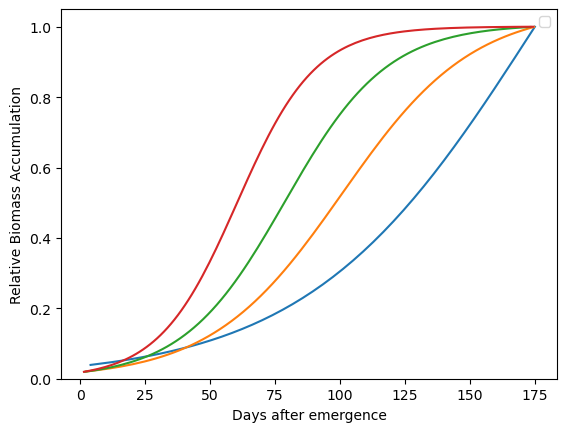

In [66]:
#Graph = plt.figure(figsize=(5,5))
#ax = Graph.add_subplot(1,1,1)
EstabStage = 'Emergence'
ttEmergeToHarv = 175

for HarvestStage in ['Vegetative','LateReproductive','Maturity','Late']:
    scallers = calcScallers(EstabStage,HarvestStage,ttEmergeToHarv) 
    StageCorrection = 1/RelBiomAtStage[HarvestStage]
    plt.plot(scallers.index,scallers.loc[:,'Biom'] * StageCorrection,'-')
    
plt.ylabel('Relative Biomass Accumulation')
plt.xlabel('Days after emergence')
plt.ylim(0,1.05)
plt.legend()